<a href="https://colab.research.google.com/github/eolson615/SpringboardDSCareerTrack/blob/master/Capstone2_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#I will apply a random forest classifier on the Telco data set to see if it will produce a better Yes recall for the Churn category than the logistic regression model. <br><br> I will first try and use the RandomForestClassifier from sklearn with no changes to it. I will stratisfy my data on the train test split because of the imbalance in the target variable. <br><br>I try and use this intial standard model to see check which features that model is relying on the most. I fail at first because of how the OneHotEncoder function changes the data. So I run another standard random forest model, except this time I use get_dummies. This allows me to see which features the random forest model is finding important. <br><br> Next I use the SMOTE process oversampling process to see if that can help keep up both accuracy of the model and improve the recall score for Yes in the target variable. <br><br> Then I try using the undersampling method of nearmiss to address the imbalanced data and to see if it will help the random forest model in predicting a Yes in the target variable. <br><br> Finally, I compare the standard random forest model with the SMOTE and the nearmiss.

In [1]:
import warnings  #This was added for aesthetics on GitHub and was not implemented during the composition of this notebook
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imb_pipeline

In [2]:
df_url = 'https://raw.githubusercontent.com/eolson615/SpringboardDSCareerTrack/master/Capstone2/Data/telcodata_posteda.csv'
df = pd.read_csv(df_url, index_col=[0])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##The data has been loaded. I have done extensive EDA and data cleaning on this data set in previous notebooks (Capstone2_cleaningdata & Capstone2_EDA). I train test split the data, preprocess the data while setting up a pipeline, and train the model. I subsequently test the model to see how it perfoms. It scored a 0.79 on accuracy and a 0.51 on Yes recall. The overall accuracy is ok, but the Yes recall is low.

In [3]:
X = df.drop(columns=['Churn'])
y = pd.Series(df.Churn.map(dict(Yes=1, No=0)))
print(X.shape, y.shape)

(7043, 19) (7043,)


In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=56, stratify=y)
print('Xtrain', type(Xtrain), Xtrain.shape, Xtrain)
print('\n')
print('Xtest', type(Xtest), Xtest.shape, Xtest)
print('\n')
print('ytrain', type(ytrain), ytrain.shape, ytrain)
print('\n')
print('ytest', type(ytest), ytest.shape, ytest)

Xtrain <class 'pandas.core.frame.DataFrame'> (5282, 19)       gender  SeniorCitizen  ... MonthlyCharges TotalCharges
3333    Male              0  ...          19.35       212.30
1526  Female              0  ...          95.40       293.15
3336  Female              0  ...          20.30      1079.05
6451    Male              1  ...         116.25      7862.25
2192    Male              1  ...          85.65      4824.45
...      ...            ...  ...            ...          ...
5604    Male              0  ...          70.80      1207.00
4739  Female              0  ...          79.00       929.30
523   Female              0  ...          75.60      1758.60
2471  Female              0  ...          98.40      5149.50
3115  Female              0  ...          84.45      1058.60

[5282 rows x 19 columns]


Xtest <class 'pandas.core.frame.DataFrame'> (1761, 19)       gender  SeniorCitizen  ... MonthlyCharges TotalCharges
5480  Female              0  ...          45.40        45.40
4274   

In [5]:
print("ytrain")
print(ytrain.value_counts(normalize=True))
print('ytest')
print(ytest.value_counts(normalize=True))

ytrain
0    0.73457
1    0.26543
Name: Churn, dtype: float64
ytest
0    0.73481
1    0.26519
Name: Churn, dtype: float64


In [6]:
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['float64', 'int64']).columns
column_trans = make_column_transformer((OneHotEncoder(), cat_features), (StandardScaler(), num_features), remainder='passthrough')
rfc = RandomForestClassifier(n_estimators=300, random_state = 56)
rfc_pipeline = make_pipeline(column_trans, rfc)

In [7]:
rfc_pipeline.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'Multiple...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='g

In [8]:
ypred_test_unadjusted = rfc_pipeline.predict(Xtest)
class_report_test_unadjusted = classification_report(ytest, ypred_test_unadjusted)
print('Classification report for rfc unadjusted')
print(class_report_test_unadjusted)

Classification report for rfc unadjusted
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1294
           1       0.64      0.51      0.57       467

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.78      0.79      0.79      1761



In [9]:
cnf_matrix_rfc_unadjusted = confusion_matrix(ytest, ypred_test_unadjusted)
cnf_matrix_rfc_unadjusted

array([[1160,  134],
       [ 230,  237]])

##In this section I will use the RandomForest model to check on feature importance. I ended up having to rerun the rfc model without adjustment because .feature_importances_ was not able to run because of the OneHotEncoding in the pipeline. I ended up using get_dummies instead. This allowed me to be able to check the feature_importances_.

##The top 3 features are 'TotalCharges', 'tenure', and 'MonthlyCharges'.

In [10]:
Xtrain_dummies = pd.get_dummies(Xtrain, columns=cat_features, drop_first=True)
Xtest_dummies = pd.get_dummies(Xtest, columns=cat_features, drop_first=True)
rfc_dummies = RandomForestClassifier(n_estimators=300, random_state=56)
rfc_dummies.fit(Xtrain_dummies, ytrain)
ypred_test_dummies = rfc_dummies.predict(Xtest_dummies)

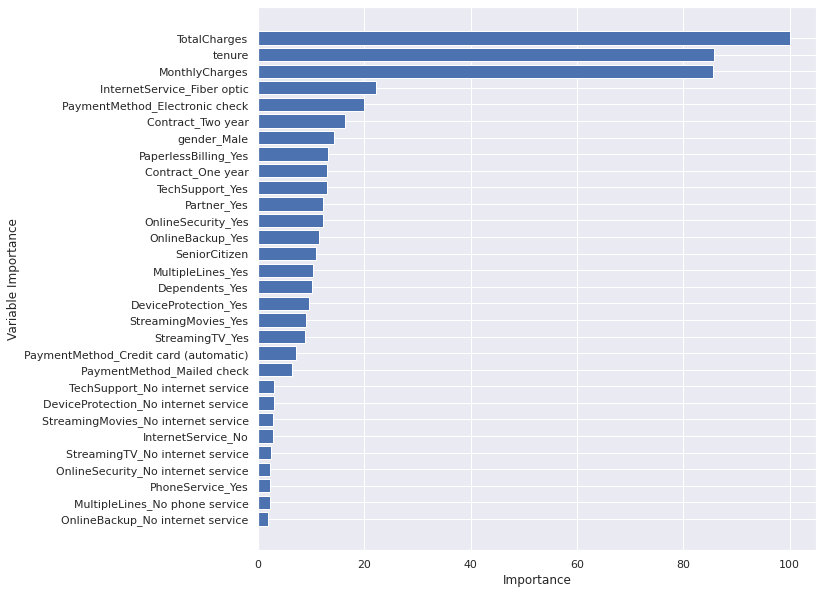

In [11]:
feature_importance = rfc_dummies.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest_dummies.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

##In this section I address the imbalanced data by using the SMOTE oversampling method. Again, I run feature_importance_. 

##The model has almost exactly the same results as the unadjusted model above with an overall accuracy score of 0.79 and a 0.52 Yes recall score.

##In the feature importance analysis, PaymentMethod_Electronic check, shot up to be almost even with MonthlyCharges, which actually dropped slightly in the feature importance rankings for this model.

In [12]:
rfc_smote = RandomForestClassifier(n_estimators=300, random_state = 56)
smote = SMOTE(random_state = 56)
smote_pipeline = imb_pipeline(smote, rfc_smote)
smote_pipeline.fit(Xtrain_dummies, ytrain)
ypred_test_smote = smote_pipeline.predict(Xtest_dummies)
class_report_test_smote = classification_report(ytest, ypred_test_smote)
print(class_report_test_smote)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1294
           1       0.64      0.52      0.57       467

    accuracy                           0.79      1761
   macro avg       0.74      0.71      0.72      1761
weighted avg       0.78      0.79      0.79      1761



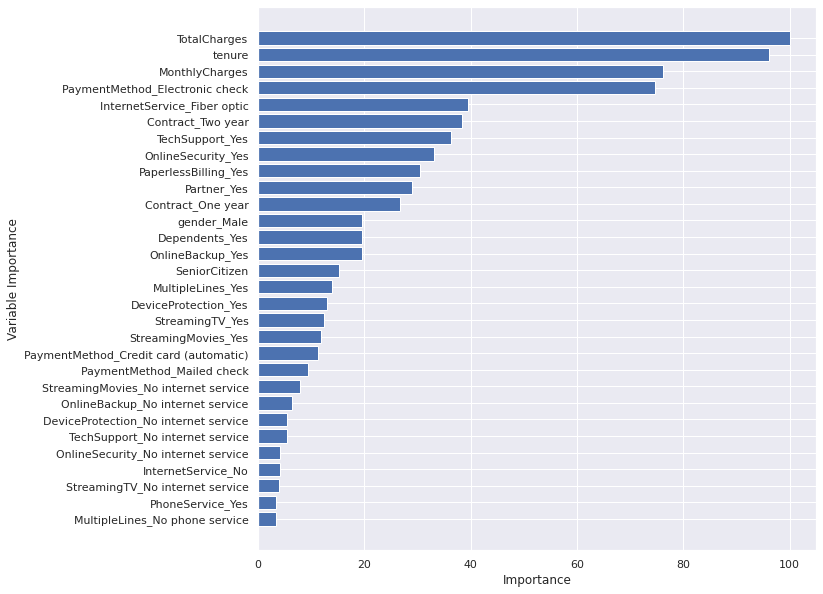

In [13]:
feature_importance = rfc_smote.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest_dummies.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

##I use the undersampling method, Nearmiss, with the RFC to address the imbalanced data situation and to see if it produces a higher Yes recall score. Again, I use get_dummies instead of OneHotEncoding so that I can use the feature_importance_ metric.

##With the Nearmiss method. The Yes recall score increased by a large amount to 0.69 but the overall accuracy decreased by an even greater margin to 0.58.

##TotalCharges, MonthlyCharges, and tenure were again the top three. Although MonthlyCharges moved up into second in rank and tenure dropped to its lowest percentage.

In [14]:
rfc_nearmiss = RandomForestClassifier(n_estimators=300, random_state=56)
nearmiss = NearMiss(random_state = 56)
nearmiss_pipeline = imb_pipeline(nearmiss, rfc_nearmiss)
nearmiss_pipeline.fit(Xtrain_dummies, ytrain)
ypred_test_nearmiss = nearmiss_pipeline.predict(Xtest_dummies)
class_report_test_nearmiss = classification_report(ytest, ypred_test_nearmiss)
print(class_report_test_nearmiss)

              precision    recall  f1-score   support

           0       0.83      0.54      0.65      1294
           1       0.35      0.69      0.47       467

    accuracy                           0.58      1761
   macro avg       0.59      0.62      0.56      1761
weighted avg       0.70      0.58      0.60      1761



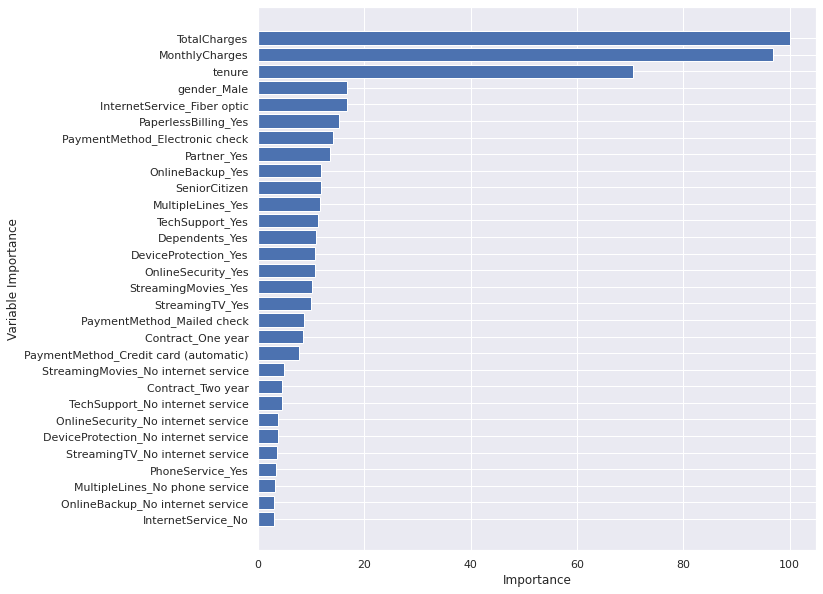

In [15]:
feature_importance = rfc_nearmiss.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtest_dummies.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

##I compare the RandomForestClassifier models I have trained and tested.

##The standard unadjusted RFC model and the SMOTE adjusted models perform almost identically. The Nearmiss adjusted model swung in the opposite direction and performed better on the Yes recall score but worse on the overall accuracy of the model. This noticeable in both visuals, the scatter plot and the ROC curve.

In [16]:
print('Standard RFC model'),
print(class_report_test_unadjusted),
print('SMOTE RFC model'),
print(class_report_test_smote),
print('Nearmiss RFC model')
print(class_report_test_nearmiss)

Standard RFC model
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1294
           1       0.64      0.51      0.57       467

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.78      0.79      0.79      1761

SMOTE RFC model
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1294
           1       0.64      0.52      0.57       467

    accuracy                           0.79      1761
   macro avg       0.74      0.71      0.72      1761
weighted avg       0.78      0.79      0.79      1761

Nearmiss RFC model
              precision    recall  f1-score   support

           0       0.83      0.54      0.65      1294
           1       0.35      0.69      0.47       467

    accuracy                           0.58      1761
   macro avg       0.59      0.62      0.56      1761
weighted avg       0

In [17]:
cnf_matrix_smote_rfc = confusion_matrix(ytest, ypred_test_smote)
cnf_matrix_nearmiss_rfc = confusion_matrix(ytest, ypred_test_nearmiss)
print('Confusion Matrix for unadjusted RFC model'),
print(cnf_matrix_rfc_unadjusted),
print('Confusion Matrix for SMOTE RFC model'),
print(cnf_matrix_smote_rfc),
print('Confusion Matrix for Nearmiss RFC model'),
print(cnf_matrix_nearmiss_rfc)

Confusion Matrix for unadjusted RFC model
[[1160  134]
 [ 230  237]]
Confusion Matrix for SMOTE RFC model
[[1154  140]
 [ 223  244]]
Confusion Matrix for Nearmiss RFC model
[[696 598]
 [143 324]]


In [18]:
list_model_tests = ['rfc_notadjusted', 'rfc_smote', 'rfc_nearmiss']
list_ypred_tests = [ypred_test_unadjusted, ypred_test_smote, ypred_test_nearmiss]
dict_for_pred_scores = {}
list_recall_scores = []
list_accuracy_scores = []

for ypred in list_ypred_tests:
  recallscore = recall_score(ytest, ypred) * 100
  list_recall_scores.append(recallscore)
  accuracyscore = accuracy_score(ytest, ypred) * 100
  list_accuracy_scores.append(accuracyscore)

dict_for_pred_scores['model'] = list_model_tests
dict_for_pred_scores['recall_score'] = list_recall_scores
dict_for_pred_scores['accuracy_score'] = list_accuracy_scores
df_model_scores = pd.DataFrame.from_dict(dict_for_pred_scores)
df_model_scores.to_csv('randomforce_scores.csv')
df_model_scores

,model,recall_score,accuracy_score
0,rfc_notadjusted,50.749465,79.329926
1,rfc_smote,52.248394,79.386712
2,rfc_nearmiss,69.379015,57.921635


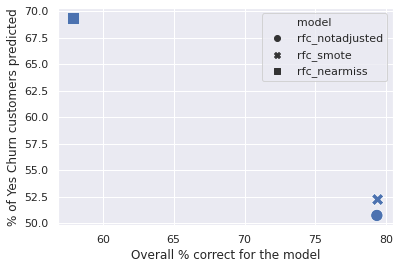

In [19]:
ax = sns.scatterplot(x="accuracy_score", y="recall_score",
                    style="model", data=df_model_scores, s=150)
_ = plt.ylabel('% of Yes Churn customers predicted')
_ = plt.xlabel('Overall % correct for the model')
plt.show()

This is ROC curve and the AUC score for the 3 RandomForestClassifier models ran


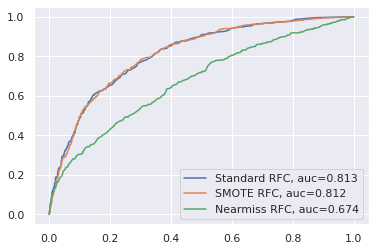

In [20]:
ypred_prob_originalrfc = rfc_pipeline.predict_proba(Xtest)[::,1]
fpr, tpr, _ = roc_curve(ytest, ypred_prob_originalrfc)
auc = roc_auc_score(ytest, ypred_prob_originalrfc)

ypred_prob_smoterfc = smote_pipeline.predict_proba(Xtest_dummies)[::,1]
fpr_smoterfc, tpr_smoterfc, _ = roc_curve(ytest, ypred_prob_smoterfc)
auc_smoterfc = roc_auc_score(ytest, ypred_prob_smoterfc)

ypred_prob_nearmissrfc = rfc_nearmiss.predict_proba(Xtest_dummies)[::,1]
fpr_nearmissrfc, tpr_nearmissrfc, _ = roc_curve(ytest, ypred_prob_nearmissrfc)
auc_nearmissrfc = roc_auc_score(ytest, ypred_prob_nearmissrfc)

_ = plt.plot(fpr, tpr, label='Standard RFC, auc='+ str(round(auc, 3)))
_ = plt.plot(fpr_smoterfc, tpr_smoterfc, label='SMOTE RFC, auc='+ str(round(auc_smoterfc, 3)))
_ = plt.plot(fpr_nearmissrfc, tpr_nearmissrfc, label='Nearmiss RFC, auc='+ str(round(auc_nearmissrfc, 3)))
_ = plt.legend(loc='best')
print("This is ROC curve and the AUC score for the 3 RandomForestClassifier models ran")
plt.show()

In [21]:
from google.colab import files
files.download('randomforce_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>